In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import joblib

In [59]:
# Load the dataset
df = pd.read_csv('processed_coconut_data.csv')
df.head(2)

,Date,Soil Moisture (10 cm) (%),Soil Moisture (20 cm) (%),Soil Moisture (30 cm) (%),Plant Age (years),Temperature (°C),Humidity (%),Rainfall (mm),Rain Status (0/1),Soil Type,Soil Type (Numeric),Coconut Count
0,1930-05-31,25.247752,31.329343,41.908014,5,27.276334,67.448574,5.012583,1,Red Yellow Podzolic,4.0,311.0
1,1930-06-30,25.247752,31.329343,41.908014,4,27.276334,67.448574,5.012583,1,Red Yellow Podzolic,4.0,311.0


In [60]:
X = df.drop(['Date','Rain Status (0/1)','Coconut Count', 'Soil Type'], axis=1) 
y = df['Coconut Count']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Initialize models
models = {
   'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
   'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
   'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1),
   'ANN': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
   'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [72]:
from sklearn.metrics import mean_squared_error

def calculate_accuracy(y_true, y_pred):
   mse = mean_squared_error(y_true, y_pred)
   rmse = np.sqrt(mse)
   accuracy = 100 * (1 - rmse / np.mean(y_true))
   return rmse, max(0, accuracy)

In [73]:
results = {}
best_score = float('-inf')
best_model = None

for name, model in models.items():
   model.fit(X_train, y_train)
   y_pred = model.predict(X_test)
   
   rmse, accuracy = calculate_accuracy(y_test, y_pred)
   r2 = r2_score(y_test, y_pred) * 100  # Convert to percentage
   cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
   cv_percentage = cv_scores.mean() * 100
   
   results[name] = {
       'RMSE': rmse,
       'Accuracy': accuracy,
       'R2_Percentage': r2,
       'CV_Accuracy': cv_percentage,
       'CV_std': cv_scores.std() * 100
   }
   
   if cv_scores.mean() > best_score:
       best_score = cv_scores.mean()
       best_model = model

In [77]:
# Print results in a formatted way
print("\nModel Evaluation Results:")
print("-" * 80)
for name, metrics in results.items():
    print(f"\nModel: {name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")
    print("-" * 40)

print(f"\nBest Model: {type(best_model).__name__}")
print(f"Best CV Score: {best_score:.4f}")


Model Evaluation Results:
--------------------------------------------------------------------------------

Model: Random Forest
RMSE: 31.31
Accuracy: 89.59
R2_Percentage: 5.69
CV_Accuracy: -6.76
CV_std: 2.54
----------------------------------------

Model: XGBoost
RMSE: 34.88
Accuracy: 88.41
R2_Percentage: -17.02
CV_Accuracy: -33.17
CV_std: 4.22
----------------------------------------

Model: SVR
RMSE: 32.22
Accuracy: 89.29
R2_Percentage: 0.14
CV_Accuracy: -1.01
CV_std: 0.56
----------------------------------------

Model: ANN
RMSE: 35.41
Accuracy: 88.23
R2_Percentage: -20.56
CV_Accuracy: -20.23
CV_std: 5.09
----------------------------------------

Model: Gradient Boosting
RMSE: 32.36
Accuracy: 89.25
R2_Percentage: -0.73
CV_Accuracy: -12.50
CV_std: 2.78
----------------------------------------

Best Model: SVR
Best CV Score: -0.0101



Metrics for Random Forest:
--------------------------------------------------
R² Score: 0.057
RMSE: 31.315
MAE: 27.201

Metrics for XGBoost:
--------------------------------------------------
R² Score: -0.170
RMSE: 34.881
MAE: 29.307

Metrics for SVR:
--------------------------------------------------
R² Score: 0.001
RMSE: 32.222
MAE: 28.274

Metrics for ANN:
--------------------------------------------------
R² Score: -0.206
RMSE: 35.405
MAE: 30.104

Metrics for Gradient Boosting:
--------------------------------------------------
R² Score: -0.007
RMSE: 32.362
MAE: 27.944


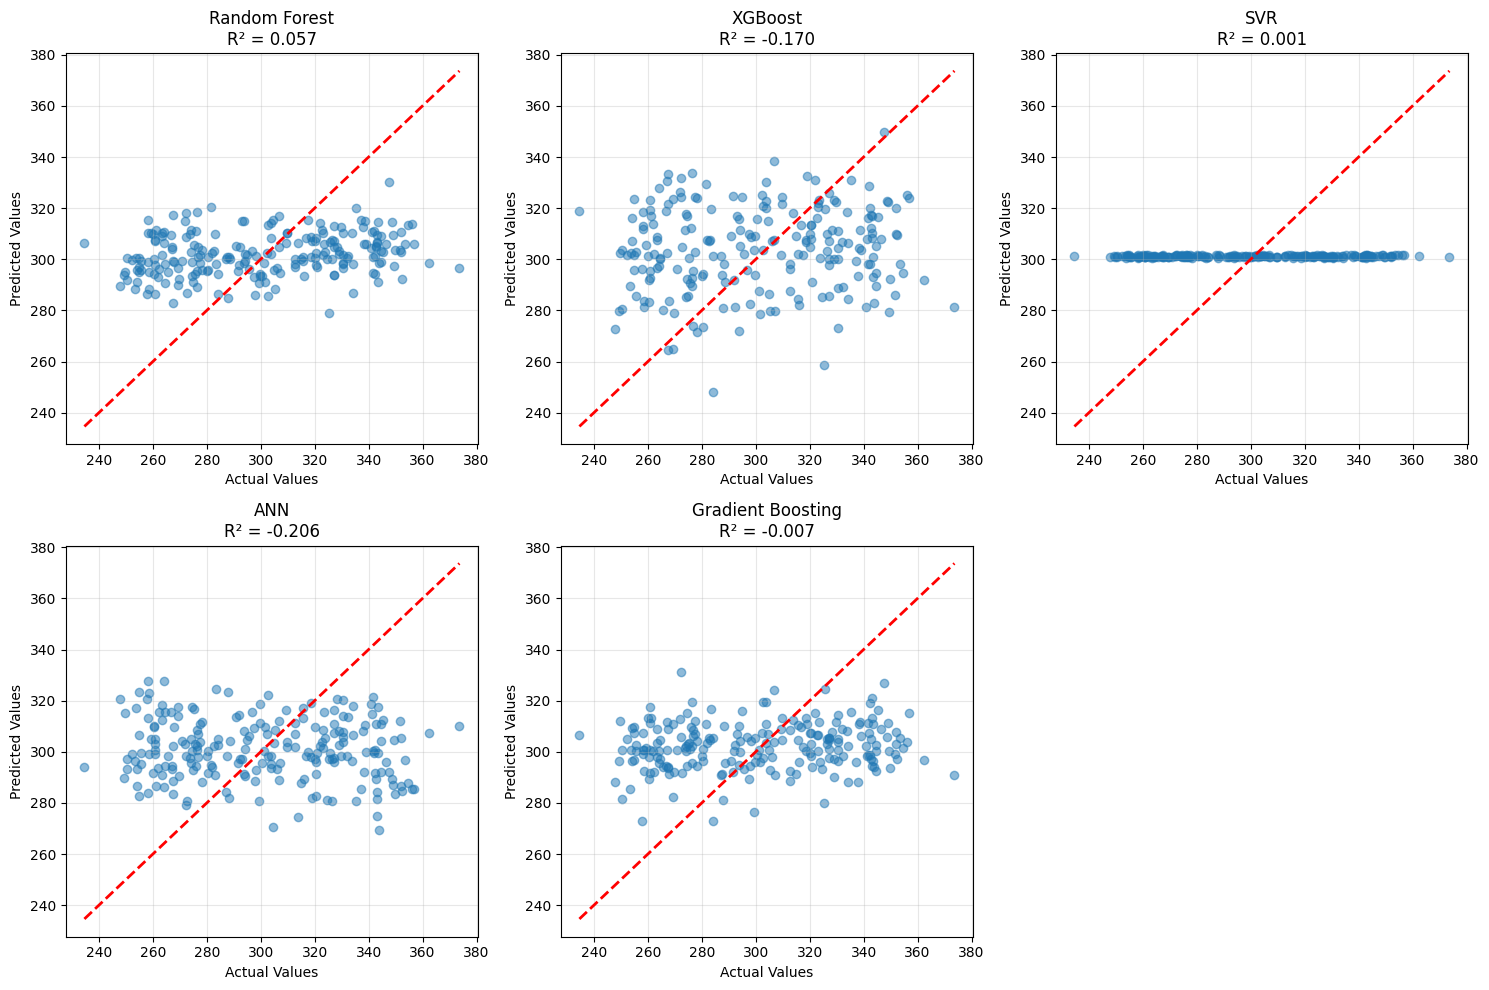

In [78]:
def plot_regression_analysis(models, X_train, X_test, y_train, y_test):
    # Calculate number of rows needed (we'll put 3 plots per row)
    n_models = len(models)
    n_rows = (n_models + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(models.items()):
        # Get predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        # Create scatter plot
        axes[idx].scatter(y_test, y_pred, alpha=0.5)
        axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                      'r--', lw=2)  # Perfect prediction line
        axes[idx].set_title(f'{name}\nR² = {r2:.3f}')
        axes[idx].set_xlabel('Actual Values')
        axes[idx].set_ylabel('Predicted Values')
        axes[idx].grid(True, alpha=0.3)
        
        # Print metrics
        print(f"\nMetrics for {name}:")
        print("-" * 50)
        print(f"R² Score: {r2:.3f}")
        print(f"RMSE: {rmse:.3f}")
        print(f"MAE: {mae:.3f}")
        
    # Remove empty subplots if any
    for idx in range(len(models), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

# Make sure to import necessary metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Plot regression analysis
plot_regression_analysis(models, X_train, X_test, y_train, y_test)

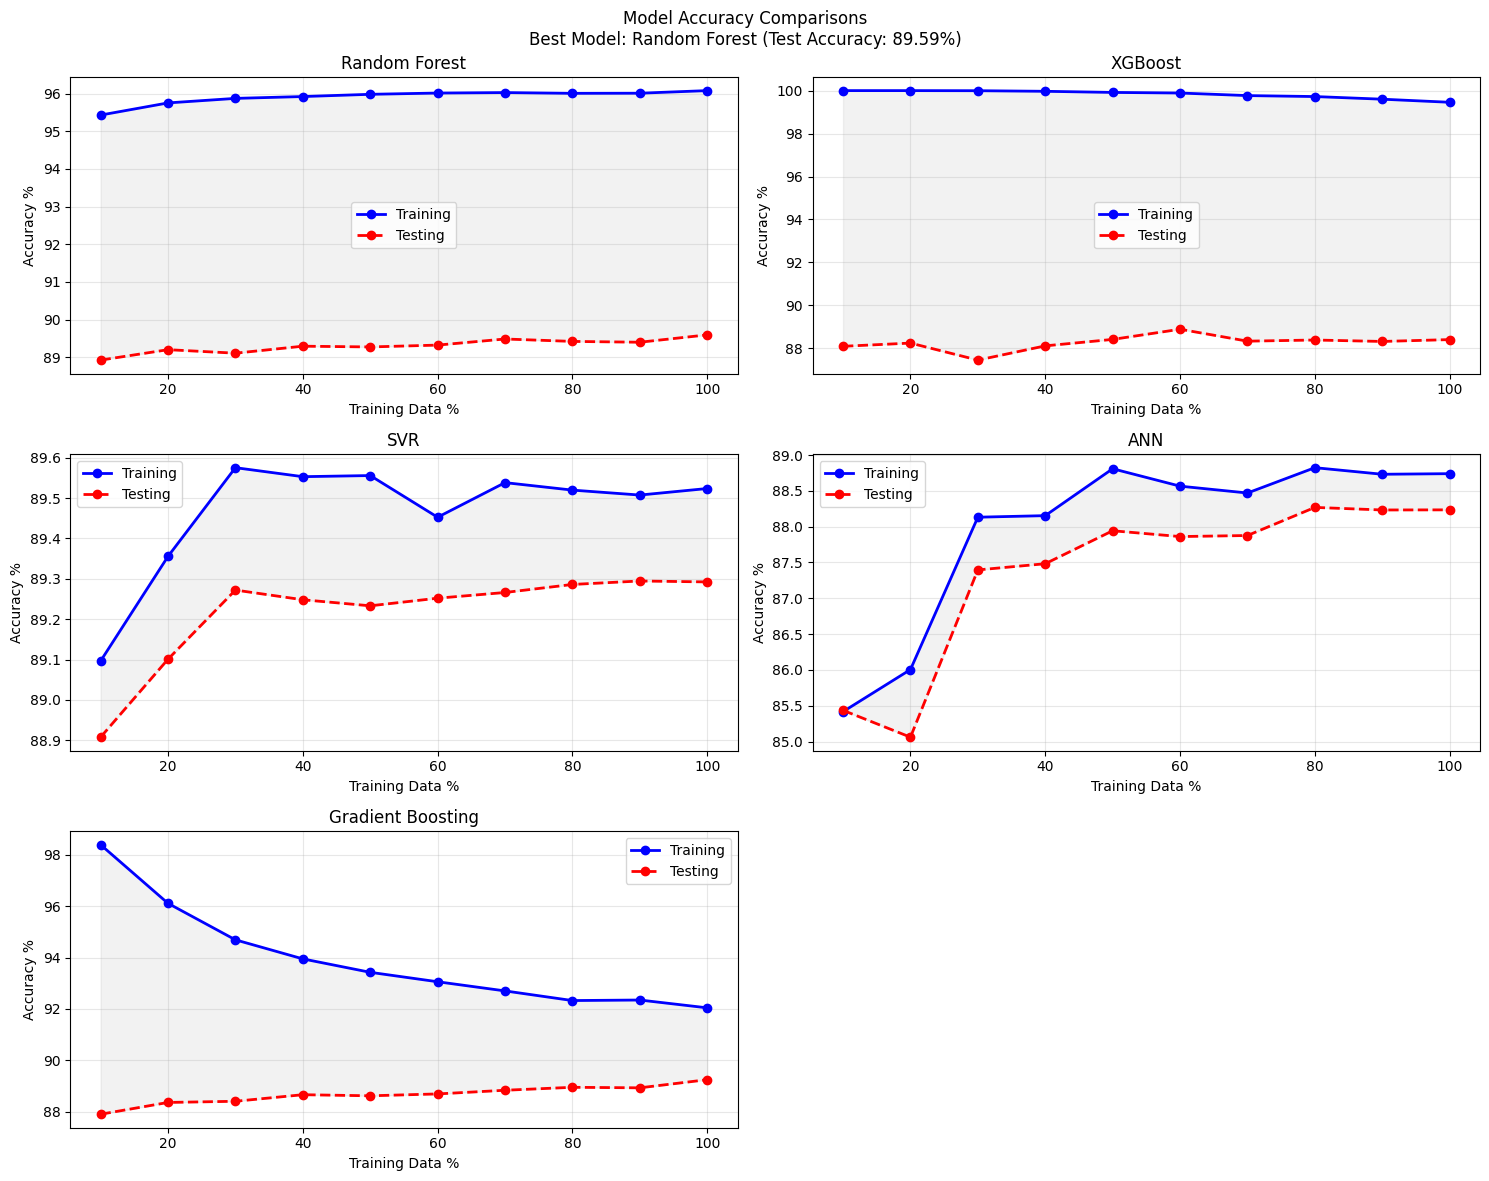


Final Accuracies for Each Model:
--------------------------------------------------

Random Forest:
Training Accuracy: 96.08%
Testing Accuracy: 89.59%

XGBoost:
Training Accuracy: 99.46%
Testing Accuracy: 88.41%

SVR:
Training Accuracy: 89.52%
Testing Accuracy: 89.29%

ANN:
Training Accuracy: 88.74%
Testing Accuracy: 88.23%

Gradient Boosting:
Training Accuracy: 92.04%
Testing Accuracy: 89.25%

Best Model: Random Forest (Test Accuracy: 89.59%)


In [66]:
import matplotlib.pyplot as plt

def plot_models_accuracy(models, X_train, X_test, y_train, y_test):
    time_points = np.linspace(0.1, 1.0, 10)
    n_samples = len(X_train)
    colors = {'Train': 'blue', 'Test': 'red'}
    best_test_acc = -np.inf
    best_model_name = None
    
    # Dictionary to store final accuracies
    final_accuracies = {}
    
    # Create figure with 3x2 subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(models.items()):
        train_accuracies = []
        test_accuracies = []
        
        for fraction in time_points:
            n_subset = int(n_samples * fraction)
            X_subset = X_train[:n_subset]
            y_subset = y_train[:n_subset]
            
            model.fit(X_subset, y_subset)
            train_pred = model.predict(X_subset)
            test_pred = model.predict(X_test)
            
            train_acc = calculate_accuracy(y_subset, train_pred)
            test_acc = calculate_accuracy(y_test, test_pred)
            
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            
            # Store final accuracies (when fraction = 1.0)
            if fraction == 1.0:
                final_accuracies[name] = {
                    'train': train_acc,
                    'test': test_acc
                }
                
                # Track best model
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    best_model_name = name
        
        axes[idx].plot(time_points * 100, train_accuracies, '-o', 
                      color=colors['Train'], label='Training', linewidth=2)
        axes[idx].plot(time_points * 100, test_accuracies, '--o', 
                      color=colors['Test'], label='Testing', linewidth=2)
        
        axes[idx].fill_between(time_points * 100, train_accuracies, 
                             test_accuracies, alpha=0.1, color='gray')
        
        axes[idx].set_xlabel('Training Data %')
        axes[idx].set_ylabel('Accuracy %')
        axes[idx].set_title(f'{name}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
        
    # Remove empty subplot
    axes[-1].remove()
    
    plt.suptitle(f'Model Accuracy Comparisons\nBest Model: {best_model_name} (Test Accuracy: {best_test_acc:.2f}%)', 
                 size=12)
    plt.tight_layout()
    plt.show()
    
    # Print final accuracies for each model
    print("\nFinal Accuracies for Each Model:")
    print("-" * 50)
    for name, accuracies in final_accuracies.items():
        print(f"\n{name}:")
        print(f"Training Accuracy: {accuracies['train']:.2f}%")
        print(f"Testing Accuracy: {accuracies['test']:.2f}%")
    
    print(f"\nBest Model: {best_model_name} (Test Accuracy: {best_test_acc:.2f}%)")

# Call function
plot_models_accuracy(models, X_train, X_test, y_train, y_test)

In [68]:
# Save the model to a file
joblib.dump(best_model, 'best_yield_predictor_for_long_trem_patterns.pkl')

['best_yield_predictor_for_long_trem_patterns.pkl']

In [69]:
import requests
import pandas as pd
import joblib
from datetime import datetime

def get_weather_data(city="Kuliyapitiya", api_key="5dd16e6569f3cdae6509d32002b9dc67"):
    """
    Get weather data from OpenWeatherMap API
    """
    base_url = "http://api.openweathermap.org/data/2.5/weather"
    
    params = {
        'q': city,
        'appid': api_key,
        'units': 'metric'
    }
    
    try:
        response = requests.get(base_url, params=params, timeout=10)  # Added timeout
        response.raise_for_status()  # Raises an HTTPError for bad responses
        data = response.json()
        
        weather_data = {
            'Temperature (°C)': data['main']['temp'],
            'Humidity (%)': data['main']['humidity'],
            'Rainfall (mm)': data.get('rain', {}).get('1h', 0),  # Improved rain data handling
            'Weather Description': data['weather'][0]['description']
        }
        return weather_data, True
            
    except requests.Timeout:
        print("Request timed out. Please check your internet connection.")
        return None, False
    except requests.RequestException as e:
        print(f"Network error occurred: {str(e)}")
        return None, False
    except KeyError as e:
        print(f"Error parsing weather data: Missing key {str(e)}")
        return None, False
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
        return None, False

def validate_soil_type(soil_type):
    """
    Validate and convert soil type to numeric value
    """
    soil_type_mapping = {
        'Lateritic': 1,
        'Sandy Loam': 2,
        'Cinnamon Sand': 3,
        'Red Yellow Podzolic': 4,
        'Alluvial': 5
    }
    
    if isinstance(soil_type, str):
        return soil_type_mapping.get(soil_type)
    elif isinstance(soil_type, int) and soil_type in soil_type_mapping.values():
        return soil_type
    else:
        raise ValueError("Invalid soil type. Must be one of: " + 
                        ", ".join(soil_type_mapping.keys()) +
                        f" or their numeric values (1-{len(soil_type_mapping)})")

def predict_yield_with_weather(soil_moisture_data, api_key):
    """
    Predict coconut yield using soil moisture, soil type, and weather data
    """
    # Validate inputs
    required_fields = ['sm_10', 'sm_20', 'sm_30', 'age', 'soil_type']
    if not all(field in soil_moisture_data for field in required_fields):
        missing_fields = [field for field in required_fields if field not in soil_moisture_data]
        print(f"Missing required fields: {', '.join(missing_fields)}")
        return None
    
    try:
        # Validate soil type
        soil_type_numeric = validate_soil_type(soil_moisture_data['soil_type'])
        
        # Get weather data
        weather_data, success = get_weather_data(api_key=api_key)
        
        if not success:
            return None
        
        # Combine soil moisture and weather data
        input_data = pd.DataFrame({
            'Soil Moisture (10 cm) (%)': [soil_moisture_data['sm_10']],
            'Soil Moisture (20 cm) (%)': [soil_moisture_data['sm_20']],
            'Soil Moisture (30 cm) (%)': [soil_moisture_data['sm_30']],
            'Plant Age (years)': [soil_moisture_data['age']],
            'Temperature (°C)': [weather_data['Temperature (°C)']],
            'Humidity (%)': [weather_data['Humidity (%)']],
            'Rainfall (mm)': [weather_data['Rainfall (mm)']],
            'Soil Type (Numeric)': [soil_type_numeric]
        })
        
        # Print all input parameters
        print("\nInput Parameters:")
        print("-----------------")
        print(f"Soil Moisture at 10cm: {soil_moisture_data['sm_10']}%")
        print(f"Soil Moisture at 20cm: {soil_moisture_data['sm_20']}%")
        print(f"Soil Moisture at 30cm: {soil_moisture_data['sm_30']}%")
        print(f"Plant Age: {soil_moisture_data['age']} years")
        print(f"Soil Type: {soil_moisture_data['soil_type']}")
        print(f"Temperature: {weather_data['Temperature (°C)']}°C")
        print(f"Humidity: {weather_data['Humidity (%)']}%")
        print(f"Rainfall: {weather_data['Rainfall (mm)']}mm")
        print(f"Weather Description: {weather_data['Weather Description']}")
        
        # Load model and make prediction
        try:
            model = joblib.load('best_yield_predictor_for_long_trem_patterns.pkl')
            prediction = model.predict(input_data)
            return prediction[0]
        except FileNotFoundError:
            print("Error: Model file not found. Please ensure the model file exists.")
            return None
        except Exception as e:
            print(f"Error making prediction: {str(e)}")
            return None
            
    except ValueError as e:
        print(f"Validation error: {str(e)}")
        return None
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
        return None

# Example usage
if __name__ == "__main__":
    API_KEY = "5dd16e6569f3cdae6509d32002b9dc67"
    
    # Example soil moisture data with soil type
    soil_data = {
        'sm_10': 19.89,
        'sm_20': 41.67,
        'sm_30': 34.82,
        'age': 3,
        'soil_type': 'Sandy Loam'  # or numeric value 2
    }
    
    # Get prediction
    prediction = predict_yield_with_weather(soil_data, API_KEY)
    
    if prediction is not None:
        print(f"\nPredicted Coconut Yield: {prediction:.2f}")
        

            
        print("\nPrediction Time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


Input Parameters:
-----------------
Soil Moisture at 10cm: 19.89%
Soil Moisture at 20cm: 41.67%
Soil Moisture at 30cm: 34.82%
Plant Age: 3 years
Soil Type: Sandy Loam
Temperature: 30.09°C
Humidity: 58%
Rainfall: 0mm
Weather Description: scattered clouds

Predicted Coconut Yield: 302.20

Prediction Time: 2024-12-04 09:31:12
